Hello Fellow Kagglers,

This is notebook demonstrates the generation of 16 million training pairs, using 15 neighbours.

For each point of interest all combination of pairs are added to the training data, as are the 15 nearest neighbours.

This training set is much larger than the 600K pairs provided in the competition dataset.

Moreover, the provided pairs dataset is heavily skewed towards positive samples (68% matches), whereas the generated pairs dataset containing all pairs and all 15 nearest neighbours consists of just 11% positive samples, making the training dataset more representable for the expected pairs when performing inference on the 15 nearest neighbours.

15 neighbours are chosen to make the training dataset as large as possible, while still fitting in the 16GB notebooks when computing features and training.

A quick analysis is provided to demonstrate the marginal value of additional nearest neighbours.

As expected, the match ratio decreases as the number of neighbours increases.

Other notebooks:

[Foursquare USE/MPNET Name Embeddings](https://www.kaggle.com/code/markwijkhuizen/foursquare-use-mpnet-name-embeddings)

Training/Inference notebook coming soon!

In [1]:
# Used to deduce city/country from coordinates
!pip install /kaggle/input/reversegeocode/reverse_geocode-1.4.1-py3-none-any.whl

Processing /kaggle/input/reversegeocode/reverse_geocode-1.4.1-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import backend as K
from Levenshtein import distance as lev
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn import metrics
from multiprocessing import cpu_count
from sklearn.neighbors import BallTree
from difflib import SequenceMatcher

import geopy.distance
import reverse_geocode
import math
import scipy
import numba
import warnings
import Levenshtein
import itertools
import gc
import psutil
import sys

# Pandas Apply With Progress Bar
tqdm.pandas()

# Plot DPI
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

# Tensorflow Version
print(f'Tensorflow version {tf.__version__}')

# Ignore Warnings
warnings.filterwarnings('ignore')

Tensorflow version 2.6.4


In [3]:
SEED = 42
DEBUG = False
# Earths Radius in KM
EARTH_RADIUS = 6371

# Load Train/Test Data

In [4]:
%%time
# Train
train_dtype = {
    'id': 'category',
    'name': 'category',
    'address': 'category',
    'city': 'category',
    'state': 'category',
    'zip': 'category',
    'country': 'category',
    'url': 'category',
    'phone': 'category',
    'categories': 'category',
    'latitude': np.float32,
    'longitude': np.float32,
}
train = pd.read_csv('/kaggle/input/foursquare-location-matching/train.csv', index_col='id', dtype=train_dtype)
train['id'] = train.index.values
display(train.info(memory_usage=True))
display(train.head())
display(train.memory_usage(deep=True) / len(train))

# Test
test_usecols = [
    'id',
    'name',
    'latitude',
    'longitude',
    'address',
    'city',
    'state',
    'zip',
    'country',
    'url'
    'categories',
]

test = pd.read_csv('/kaggle/input/foursquare-location-matching/test.csv', dtype=train_dtype)
display(test.info())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1138812 entries, E_000001272c6c5d to E_ffffe6f4652fbb
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   name               1138811 non-null  category
 1   latitude           1138812 non-null  float32 
 2   longitude          1138812 non-null  float32 
 3   address            742191 non-null   category
 4   city               839623 non-null   category
 5   state              718226 non-null   category
 6   zip                543386 non-null   category
 7   country            1138801 non-null  category
 8   url                267724 non-null   category
 9   phone              342855 non-null   category
 10  categories         1040505 non-null  category
 11  point_of_interest  1138812 non-null  object  
 12  id                 1138812 non-null  category
dtypes: category(10), float32(2), object(1)
memory usage: 225.7+ MB


None

,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,id
id,,,,,,,,,,,,,
E_000001272c6c5d,Café Stad Oudenaarde,50.859974,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,E_000001272c6c5d
E_000002eae2a589,Carioca Manero,-22.907225,-43.178246,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,E_000002eae2a589
E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484901,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,E_000007f24ebc95
E_000008a8ba4f48,Turkcell,37.844509,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,E_000008a8ba4f48
E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,E_00001d92066153


Index                106.694643
name                 106.860765
latitude               4.000000
longitude              4.000000
address               66.353886
city                  10.581007
state                  3.745623
zip                   11.076517
country                2.018734
url                   22.719279
phone                 28.896098
categories            10.447042
point_of_interest     73.000000
id                   106.694643
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          5 non-null      category
 1   name        5 non-null      category
 2   latitude    5 non-null      float32 
 3   longitude   5 non-null      float32 
 4   address     3 non-null      category
 5   city        3 non-null      category
 6   state       2 non-null      category
 7   zip         2 non-null      category
 8   country     5 non-null      category
 9   url         1 non-null      category
 10  phone       1 non-null      category
 11  categories  5 non-null      category
dtypes: category(10), float32(2)
memory usage: 1.4 KB


None

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,Jamu Petani Bagan Serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cafés
1,E_000020eb6fed40,Johnny's Bar,40.434208,-80.564163,497 N 12th St,Weirton,WV,26062,US,NaN,NaN,Bars
2,E_00002f98667edf,QIWI,47.215134,39.686089,"Межевая улица, 60",Ростов-на-Дону,NaN,NaN,RU,https://qiwi.com,+78003011131,ATMs
3,E_001b6bad66eb98,"Gelora Sriwijaya, Jaka Baring Sport City",-3.014675,104.794373,NaN,NaN,NaN,NaN,ID,NaN,NaN,Stadiums
4,E_0283d9f61e569d,Stadion Gelora Sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480.0,ID,NaN,NaN,Soccer Stadiums


CPU times: user 26.5 s, sys: 1.14 s, total: 27.6 s
Wall time: 30 s


# Load Pairs

In [5]:
# Pairs
pairs_dtype = {
    'id_1': 'category',
    'id_2': 'category',
    'name_1': 'category',
    'name_2': 'category',
    'address_1': 'category',
    'address_1': 'category',
    'city_1': 'category',
    'city_2': 'category',
    'state_1': 'category',
    'state_2': 'category',
    'zip_1': 'category',
    'zip_2': 'category',
    'country_1': 'category',
    'country_2': 'category',
    'url_1': 'category',
    'url_2': 'category',
    'phone_1': 'category',
    'phone_2': 'category',
    'categories_1': 'category',
    'categories_2': 'category',
    'latitude_1': np.float32,
    'longitude_1': np.float32,
    'latitude_2': np.float32,
    'longitude_2': np.float32,
}
pd.options.display.max_rows = 99
pd.options.display.max_columns = 99

pairs_sample = pd.read_csv('/kaggle/input/foursquare-location-matching/pairs.csv', dtype=pairs_dtype, skiprows=lambda idx: idx > 5)
display(pairs_sample.info())
display(pairs_sample.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id_1          5 non-null      category
 1   name_1        5 non-null      category
 2   latitude_1    5 non-null      float32 
 3   longitude_1   5 non-null      float32 
 4   address_1     5 non-null      category
 5   city_1        4 non-null      category
 6   state_1       4 non-null      category
 7   zip_1         3 non-null      category
 8   country_1     5 non-null      category
 9   url_1         1 non-null      category
 10  phone_1       1 non-null      category
 11  categories_1  5 non-null      category
 12  id_2          5 non-null      category
 13  name_2        5 non-null      category
 14  latitude_2    5 non-null      float32 
 15  longitude_2   5 non-null      float32 
 16  address_2     2 non-null      object  
 17  city_2        3 non-null      category
 18  state_2       

None

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859974,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,E_da7fa3963561f8,Café Oudenaarde,50.869358,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844509,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,E_3f12df0b045062,Turkcell,37.838020,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018700,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,NaN,Spas,E_12453effe251db,Island Spa Theater,14.518330,121.019829,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064598,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,7074394747,Sandwich Places,E_f131dcb7f07be9,Togo's,38.257938,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610245,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops",E_d52c3c4d53831c,Coffeecat,7.076016,125.611458,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


# Load Sample Submission

In [6]:
# Sample Submission
sample_submission = pd.read_csv('/kaggle/input/foursquare-location-matching/sample_submission.csv')
display(sample_submission.info())
display(sample_submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       5 non-null      object
 1   matches  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


None

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


# To Lower

In [7]:
# Cast columns to lower case to be case agnostic
to_lower_columns = [
    'name',
    'state',
    'country',
    'city',
    'address',
    'zip',
    'phone',
    'url',
    'categories',
]

def to_lower(df):
    f = lambda v: '' if v == 'NaN' else v.lower()
    for col in to_lower_columns:
        if f'{col}_1' in df and f'{col}_2' in df:
            df[f'{col}_1'] = df[f'{col}_1'].astype(str, copy=False).str.lower().replace('nan', '').astype('category')
            df[f'{col}_2'] = df[f'{col}_2'].astype(str, copy=False).str.lower().replace('nan', '').astype('category')
        else:
            df[col] = df[col].astype(str, copy=False).str.lower().replace('nan', '').astype('category')
            
to_lower(train)
to_lower(pairs_sample)
to_lower(test)

In [8]:
display(train.head())

,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,id
id,,,,,,,,,,,,,
E_000001272c6c5d,café stad oudenaarde,50.859974,3.634196,abdijstraat,nederename,oost-vlaanderen,9700,be,,,bars,P_677e840bb6fc7e,E_000001272c6c5d
E_000002eae2a589,carioca manero,-22.907225,-43.178246,,,,,br,,,brazilian restaurants,P_d82910d8382a83,E_000002eae2a589
E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484901,,,,,th,,,salons / barbershops,P_b1066599e78477,E_000007f24ebc95
E_000008a8ba4f48,turkcell,37.844509,27.844202,adnan menderes bulvarı,,,,tr,,,mobile phone shops,P_b2ed86905a4cd3,E_000008a8ba4f48
E_00001d92066153,restaurante casa cofiño,43.338196,-4.326821,,caviedes,cantabria,,es,,,spanish restaurants,P_809a884d4407fb,E_00001d92066153


In [9]:
display(pairs_sample.head())

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,café stad oudenaarde,50.859974,3.634196,abdijstraat,nederename,oost-vlaanderen,9700,be,,,bars,E_da7fa3963561f8,café oudenaarde,50.869358,3.635206,,,,,be,,,bars,True
1,E_000008a8ba4f48,turkcell,37.844509,27.844202,adnan menderes bulvarı,,,,tr,,,mobile phone shops,E_3f12df0b045062,turkcell,37.838020,27.845560,batı aydın,aydın,,67500,tr,,,electronics stores,False
2,E_000023d8f4be44,island spa,14.518970,121.018700,"5th flr, newport mall, resorts world manila",pasay city,metro manila,,ph,,,spas,E_12453effe251db,island spa theater,14.518330,121.019829,,,,,ph,,,spas,True
3,E_00007dcd2bb53f,togo's sandwiches,38.257797,-122.064598,"1380 holiday ln., ste. b",fairfield,ca,94534,us,https://locations.togos.com/ll/us/ca/fairfield...,7074394747,sandwich places,E_f131dcb7f07be9,togo's,38.257938,-122.064606,,fairfield,ca,,us,,,sandwich places,True
4,E_0000c362229d93,coffee cat,7.082218,125.610245,f. torres st.,davao city,davao region,8000,ph,,,"cafés, coffee shops",E_d52c3c4d53831c,coffeecat,7.076016,125.611458,e. jacinto extension,davao city,davao region,8000,ph,,,"coffee shops, cafés, dessert shops",False


In [10]:
display(test.head())

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,jamu petani bagan serai,5.012169,100.535805,,,,,my,,,cafés
1,E_000020eb6fed40,johnny's bar,40.434208,-80.564163,497 n 12th st,weirton,wv,26062,us,,,bars
2,E_00002f98667edf,qiwi,47.215134,39.686089,"межевая улица, 60",ростов-на-дону,,,ru,https://qiwi.com,+78003011131,atms
3,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794373,,,,,id,,,stadiums
4,E_0283d9f61e569d,stadion gelora sriwijaya,-3.021727,104.788628,jalan gubernur hasan bastari,palembang,south sumatra,11480.0,id,,,soccer stadiums


# Number of Neighbours Analysis

In [11]:
def plot_n_matches_by_n_neighbours():
    # Mapping a point of interest to all corresponding ids
    poi2ids = train.groupby('point_of_interest')['id'].apply(set).apply(list).apply(np.sort).to_dict()
    # The famous nearest neighbours graph used in all notebooks
    tree = BallTree(np.deg2rad(train[['latitude', 'longitude']].values), metric='haversine')
    N_NEIGHBOURS_CHECK = 31

    matches_count_dict = dict([(n,dict()) for n in range(1, N_NEIGHBOURS_CHECK)])
    for n in range(1, N_NEIGHBOURS_CHECK):
        matches_count_dict[n]['sum'] = 0
        matches_count_dict[n]['count'] = 0

    for row_idx, row in tqdm(train.iterrows(), total=len(train)):
        row_dict = {}
        distances, indices = tree.query(
                    np.deg2rad([row['latitude'], row['longitude']]).reshape(1, -1),
                    k=N_NEIGHBOURS_CHECK,
                )
        indices = indices[0]
        match_ids = set(poi2ids[row['point_of_interest']])
        query_ids = train.iloc[indices]['id'].values
        for n in range(1, N_NEIGHBOURS_CHECK):
            for ind in query_ids[:n]:
                matches_count_dict[n]['count'] += 1
                if ind in match_ids:
                    matches_count_dict[n]['sum'] += 1

    for n in range(1, N_NEIGHBOURS_CHECK):
        matches_count_dict[n]['total_match_ratio (%)'] = matches_count_dict[n]['sum'] / matches_count_dict[n]['count'] * 100


    matches_count_dict_df = pd.DataFrame(matches_count_dict).T.astype({'sum': np.int32, 'count': np.int32})
    # Add Marginal Sum
    matches_count_dict_df['sum_marginal'] = (
            matches_count_dict_df['sum'] - matches_count_dict_df['sum'].shift(1)
        ).fillna(matches_count_dict_df.loc[1, 'sum']).astype(np.int32)
    
    # Add Non Self Sum
    matches_count_dict_df['sum_non_self'] = (matches_count_dict_df['sum'] - len(train)).astype(np.int32)
    
    # Add Percentage Ratio
    matches_count_dict_df['match_ratio (%)'] = ((matches_count_dict_df['sum_marginal'] / len(train)) * 100 ).astype(np.float32)

    pd.options.display.max_rows = 999
    display(matches_count_dict_df)

    plt.figure(figsize=(12,5))
    plt.title('Number of Matches by Number of Neighbours', size=18)
    plt.plot(matches_count_dict_df['sum'])
    plt.xlabel('Number of Neighbours', size=16)
    plt.xlabel('Number of Matches', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.ylim(0)
    plt.grid()
    plt.show()

  0%|          | 0/1138812 [00:00<?, ?it/s]

,sum,count,total_match_ratio (%),sum_marginal,sum_non_self,match_ratio (%)
1,1134662,1138812,99.635585,1134662,-4150,99.635582
2,1487917,2277624,65.327596,353255,349105,31.019606
3,1580747,3416436,46.268890,92830,441935,8.151477
4,1639974,4555248,36.001860,59227,501162,5.200771
5,1681206,5694060,29.525611,41232,542394,3.620615
6,1713987,6832872,25.084430,32781,575175,2.878526
7,1740993,7971684,21.839714,27006,602181,2.371419
8,1763982,9110496,19.362085,22989,625170,2.018683
9,1784192,10249308,17.407926,20210,645380,1.774656
10,1802316,11388120,15.826282,18124,663504,1.591483


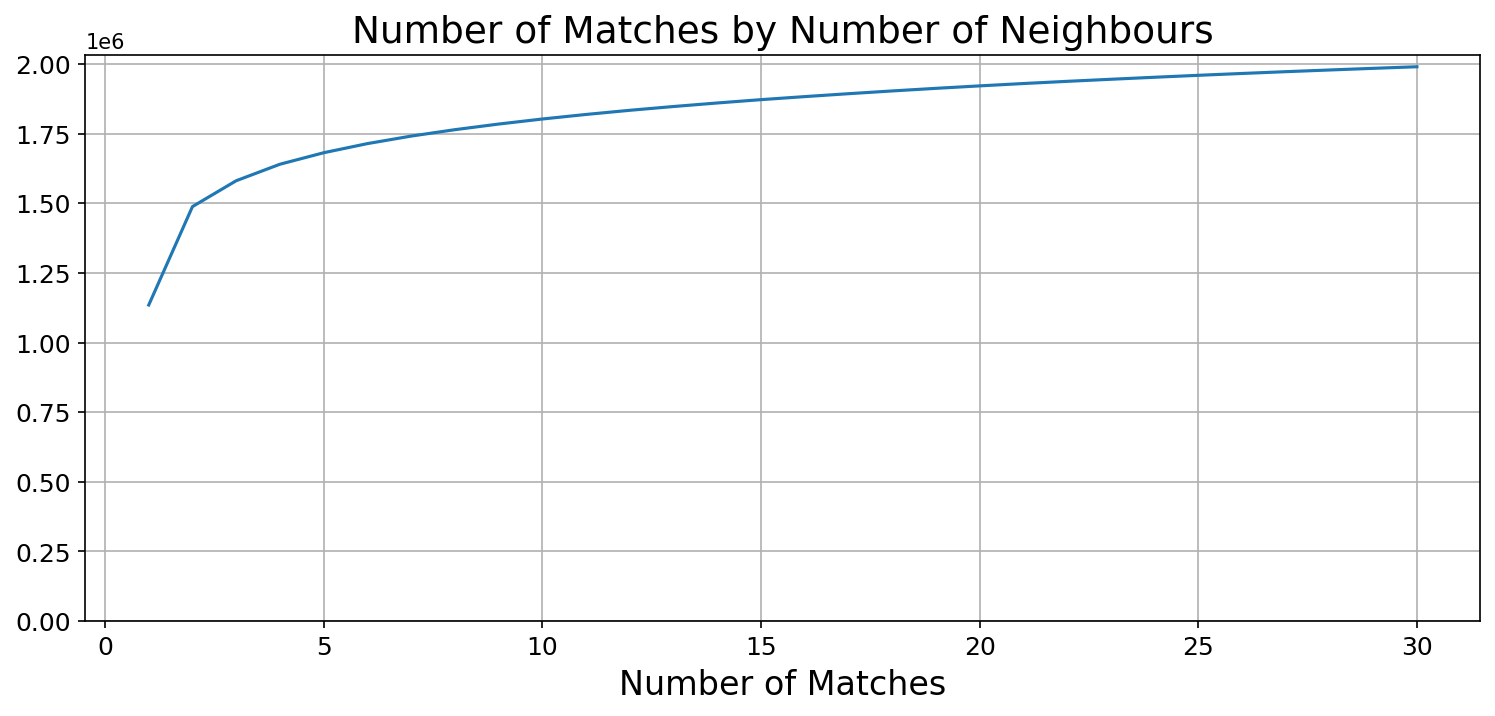

In [12]:
"""
sum:                   total matches
count:                 total pairs
total_match_ratio (%): global percentage of matches in pairs (positive ratio)
sum_marginal:          pairs in current nearest neighbour
sum_non_self:          total pairs excluding pairs referring to itself
match_ratio (%) :      match ratio in current nearest neighbouir
"""

# As can be observed, the match ratio quickly decreases
plot_n_matches_by_n_neighbours()

# Construct Pairs

In [13]:
# Source Columns
columns = ['id']

# Target Column 1
columns_1 = ['id_1']

# Target Column 2
columns_2 = ['id_2']

In [14]:
# Add a pair for 2 given ids in the training set
def add_train_sample(pairs_dict, id_1, id_2, match, count):
    pairs_dict['match'][count] = match
    pairs_dict['match'][count + 1] = match
    row_1 = train.loc[id_1, columns]
    row_2 = train.loc[id_2, columns]
    for col_idx, (col, col_1, col_2) in enumerate(zip(columns, columns_1, columns_2)):
        if col_idx == 1 or col_idx == 2:
            pairs_dict[col_1][count] = row_1[col_idx]
            pairs_dict[col_2][count] = row_2[col_idx]
            pairs_dict[col_1][count + 1] = row_2[col_idx]
            pairs_dict[col_2][count + 1] = row_1[col_idx]
        else:
            pairs_dict[col_1][count] = row_1[col_idx]
            pairs_dict[col_2][count] = row_2[col_idx]
            pairs_dict[col_1][count + 1] = row_2[col_idx]
            pairs_dict[col_2][count + 1] = row_1[col_idx]

In [15]:
# Generate the pairs DataFrame
def get_pairs():
    # point of interest to corresponding ids mapping
    poi2ids = train.groupby('point_of_interest')['id'].apply(set).apply(list).apply(np.sort).to_dict()
    # nearest neighbours graph
    tree = BallTree(np.deg2rad(train[['latitude', 'longitude']].values), metric='haversine')
    # point of interest cluster size count
    display(pd.Series([len(v) for _, v in poi2ids.items()]).value_counts().head(10))
    # As it is unknown how many pairs will be generated, set the target array size to a size value of 20M
    N_TRAIN_SAMPLES = int(20e6)
    # Number of neighbours to use
    N_NEIGHBOURS = 15
    NEIGHBOURS_IDXS = np.arange(1, N_NEIGHBOURS, dtype=np.int8)
    # Set with pairs id hashes to prevent duplicate training samples
    IDS_SET = set()
    # Dictionary with dataframe columns
    pairs_dict = {
        'match': np.full(shape=N_TRAIN_SAMPLES, fill_value=np.nan, dtype=np.bool)
    }

    # Create empty array to fill up when generating pairs
    for col in columns_1 + columns_2:
        dtype = object if pd.api.types.is_categorical_dtype(pairs_sample[col]) else pairs_sample[col].dtype
        pairs_dict[col] = np.full(shape=N_TRAIN_SAMPLES, fill_value=np.nan, dtype=dtype)

    # Counter to keep track of the row to be filled
    count = 0
    # Iterate over all points of interest
    for poi, ids in tqdm(poi2ids.items()):
        # check if there are any pairs, thus more than 1 id in the point of interest
        if len(ids) > 1:
            # Generate training pair for all combinations
            for id_1, id_2 in list(itertools.combinations(ids, 2)):
                id_hash = hash(id_1 + id_2)
                if id_hash not in IDS_SET:
                    add_train_sample(pairs_dict, id_1, id_2, True, count)
                    count += 2
                    # Add hash of id1 and id2 to prevent duplicate training pairs
                    IDS_SET.update([id_hash, hash(id_2 + id_1)])

        # Get 15 nearest neighbours
        distances, indices = tree.query(
                np.deg2rad([train.loc[ids[0], 'latitude'], train.loc[ids[0], 'longitude']]).reshape(1, -1),
                k=N_NEIGHBOURS,
            )
        # Only add neighbours within 10KM and neighbours which are not matches
        indices = indices[0][ distances[0] < 10 / EARTH_RADIUS]
        query_ids = train.iloc[indices]['id'].tolist()
        query_ids = [e for e in query_ids if e not in ids]
        # Add all negative examples
        for id_2 in query_ids:
            id_hash = hash(ids[0] + id_2)
            if id_hash not in IDS_SET:
                add_train_sample(pairs_dict, ids[0], id_2, False, count)
                count += 2
                IDS_SET.update([id_hash, hash(id_2 + ids[0])])
    
    print(f'Generated {count} Training Samples!')
    return pd.DataFrame(dict([ (k, v[:count]) for k, v in pairs_dict.items()]))

In [16]:
# This is purely an dataframe with pairs of ids!
pairs = get_pairs()

# Columns to fill
columns = [
    'name', 'latitude', 'longitude', 'address', 'city',
    'state', 'zip', 'country', 'url', 'phone', 'categories',
]

columns_1 = [
    'name_1', 'latitude_1', 'longitude_1', 'address_1', 'city_1',
    'state_1', 'zip_1', 'country_1', 'url_1', 'phone_1', 'categories_1',
]

columns_2 = [
    'name_2', 'latitude_2', 'longitude_2', 'address_2', 'city_2',
    'state_2', 'zip_2', 'country_2', 'url_2', 'phone_2', 'categories_2'
]

# Fill pairs columns based on id
for col, col_1, col_2 in zip(tqdm(columns), columns_1, columns_2):
    pairs[col_1] = train.loc[pairs['id_1'], col].values
    pairs[col_2] = train.loc[pairs['id_2'], col].values

# Add hash column of id_1 and id_2 to validate unique training samples
pairs['id_hash'] = pairs[['id_1', 'id_2']].apply(lambda t: hash(t[0] + t[1]), axis=1)

# Cast ID to category
pairs['id_1'] = pairs['id_1'].astype('category')
pairs['id_2'] = pairs['id_2'].astype('category')

# Display Pairs Data
display(pairs.head(25))
display(pairs.info())

# Display Positive/Negative Sample Ratio's
display(pairs['match'].value_counts(normalize=True).to_frame())

# Unique Names
display(pairs[['name_1', 'name_2']].nunique())

1     425024
2     277722
3      24202
4       5937
5       2517
6       1327
7        839
8        520
9        368
10       261
dtype: int64

  0%|          | 0/739972 [00:00<?, ?it/s]

Generated 16421668 Training Samples!


  0%|          | 0/11 [00:00<?, ?it/s]

,match,id_1,id_2,name_1,name_2,latitude_1,latitude_2,longitude_1,longitude_2,address_1,address_2,city_1,city_2,state_1,state_2,zip_1,zip_2,country_1,country_2,url_1,url_2,phone_1,phone_2,categories_1,categories_2,id_hash
0,False,E_b4a705f3f2e85e,E_ce077098a7cf4f,pabellon t sala 6,5°a,-23.677120,-23.677223,-70.409782,-70.410149,,british school,,antofagasta,,región de antofagasta,,,cl,cl,,,,,universities,college classrooms,8055906597040789103
1,False,E_ce077098a7cf4f,E_b4a705f3f2e85e,5°a,pabellon t sala 6,-23.677223,-23.677120,-70.410149,-70.409782,british school,,antofagasta,,región de antofagasta,,,,cl,cl,,,,,college classrooms,universities,6627032894390566115
2,False,E_b4a705f3f2e85e,E_683c38e096a091,pabellon t sala 6,the antofagasta british school,-23.677120,-23.676983,-70.409782,-70.410179,,pedro león gallo 723,,antofagasta,,región de antofagasta,,,cl,cl,,http://www.colegio-abs.cl,,55598930,universities,"schools, college soccer fields",907338040651516504
3,False,E_683c38e096a091,E_b4a705f3f2e85e,the antofagasta british school,pabellon t sala 6,-23.676983,-23.677120,-70.410179,-70.409782,pedro león gallo 723,,antofagasta,,región de antofagasta,,,,cl,cl,http://www.colegio-abs.cl,,55598930,,"schools, college soccer fields",universities,-8727731115566387063
4,False,E_b4a705f3f2e85e,E_40b7276a8f110c,pabellon t sala 6,5°b,-23.677120,-23.677315,-70.409782,-70.410202,,british school,,antofagasta,,región de antofagasta,,,cl,cl,,,,,universities,college classrooms,-979411095054407766
5,False,E_40b7276a8f110c,E_b4a705f3f2e85e,5°b,pabellon t sala 6,-23.677315,-23.677120,-70.410202,-70.409782,british school,,antofagasta,,región de antofagasta,,,,cl,cl,,,,,college classrooms,universities,6282750484340128195
6,False,E_b4a705f3f2e85e,E_cc4c949a63a9cd,pabellon t sala 6,sala de computación abs,-23.677120,-23.676867,-70.409782,-70.410393,,,,,,,,,cl,cl,,,,,universities,college classrooms,8669462661867255827
7,False,E_cc4c949a63a9cd,E_b4a705f3f2e85e,sala de computación abs,pabellon t sala 6,-23.676867,-23.677120,-70.410393,-70.409782,,,,,,,,,cl,cl,,,,,college classrooms,universities,6849391740114355916
8,False,E_b4a705f3f2e85e,E_6d5c514733426c,pabellon t sala 6,parroquia madre de dios,-23.677120,-23.677984,-70.409782,-70.409523,,avda. angamos 0535,,antofagasta,,región de antofagasta,,,cl,cl,,,,,universities,churches,-3648354783306727054
9,False,E_6d5c514733426c,E_b4a705f3f2e85e,parroquia madre de dios,pabellon t sala 6,-23.677984,-23.677120,-70.409523,-70.409782,avda. angamos 0535,,antofagasta,,región de antofagasta,,,,cl,cl,,,,,churches,universities,-3614788273089267020


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16421668 entries, 0 to 16421667
Data columns (total 26 columns):
 #   Column        Dtype   
---  ------        -----   
 0   match         bool    
 1   id_1          category
 2   id_2          category
 3   name_1        category
 4   name_2        category
 5   latitude_1    float32 
 6   latitude_2    float32 
 7   longitude_1   float32 
 8   longitude_2   float32 
 9   address_1     category
 10  address_2     category
 11  city_1        category
 12  city_2        category
 13  state_1       category
 14  state_2       category
 15  zip_1         category
 16  zip_2         category
 17  country_1     category
 18  country_2     category
 19  url_1         category
 20  url_2         category
 21  phone_1       category
 22  phone_2       category
 23  categories_1  category
 24  categories_2  category
 25  id_hash       int64   
dtypes: bool(1), category(20), float32(4), int64(1)
memory usage: 1.7 GB


None

,match
False,0.884238
True,0.115762


name_1    816209
name_2    816209
dtype: int64

In [17]:
# Validate unique pairs
display(pairs['id_hash'].value_counts().value_counts(normalize=True) * 100)

1    100.0
Name: id_hash, dtype: float64

In [18]:
# Memory Usage Analysis, category data type is highly efficient!
display(pairs.memory_usage(deep=True) / len(pairs))

Index            0.000008
match            1.000000
id_1            11.115743
id_2            11.115743
name_1          11.011068
name_2          11.011068
latitude_1       4.000000
latitude_2       4.000000
longitude_1      4.000000
longitude_2      4.000000
address_1        8.278834
address_2        8.278834
city_1           4.432600
city_2           4.432600
state_1          2.108868
state_2          2.108868
zip_1            4.490318
zip_2            4.490318
country_1        2.001303
country_2        2.001303
url_1            5.297718
url_2            5.297718
phone_1          5.726501
phone_2          5.726501
categories_1     4.447094
categories_2     4.447094
id_hash          8.000000
dtype: float64

In [19]:
# Drop id_hash
pairs.drop('id_hash', axis=1, inplace=True)

# Save Training Pairs
pairs.to_pickle('pairs.pkl')

# Haversine Distance

To finish with, a simple visualisation of random pairs and matching pairs. Matching pairs are almost always within 10KM of eachother, whereas non-matching pairs are not. The distance between pairs is thus an important indicator of pairs being a match.

In [20]:
@numba.jit(nopython=True)
def haversine_np(args):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = args
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = EARTH_RADIUS * c
    return km

In [21]:
def plot_distances():
    # Get 1 random pairs of points from train
    N = int(1e6)
    # Target array for train distances
    TRAIN_DISTANCES = np.zeros(N, dtype=np.float32)
    # get random train coordinates and compute distances
    coords_a = train[['longitude', 'latitude']].sample(N, replace=True).values
    coords_b = train[['longitude', 'latitude']].sample(N, replace=True).values
    for idx, (a, b) in enumerate(tqdm(zip(coords_a, coords_b), total=N)):
        TRAIN_DISTANCES[idx] = haversine_np((*a, *b))
        
    # plot distance distribution
    plt.figure(figsize=(10,5))
    plt.title('Train Haversine Distance in KM')
    pd.Series(TRAIN_DISTANCES).plot(kind='hist', bins=10)
    plt.show()
    
    # Compute Distances for matching pairs only
    pairs_distance = pd.Series(
            np.apply_along_axis(
                haversine_np,
                1,
                pairs.loc[pairs['match'], ['longitude_1', 'latitude_1', 'longitude_2', 'latitude_2']].values.astype(np.float32)
            )
        )
    
    # Plot Distances between pairs
    plt.figure(figsize=(10,5))
    plt.title('Pairs Haversine Distance in KM')
    pairs_distance.plot(kind='hist', bins=10)
    plt.show()
    
    # Plot train/pairs/pairs_sample distance statistics
    percentiles = [0.01, 0.05, 0.10, 0.25, 0.90, 0.95, 0.99]
    display(
        pd.concat([
            pd.Series(TRAIN_DISTANCES).describe(percentiles=percentiles).to_frame(name='Train').T,
            pairs_distance.describe(percentiles=percentiles).to_frame(name='Pairs').T,
        ]).T
    )

  0%|          | 0/1000000 [00:00<?, ?it/s]

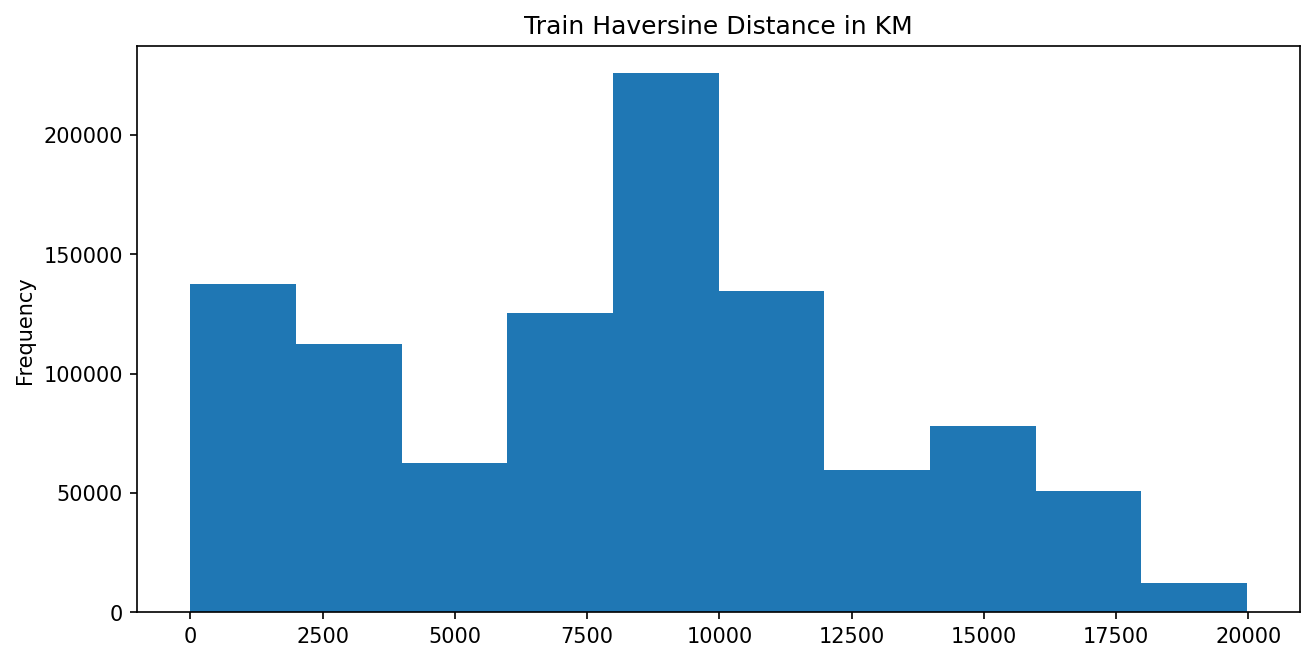

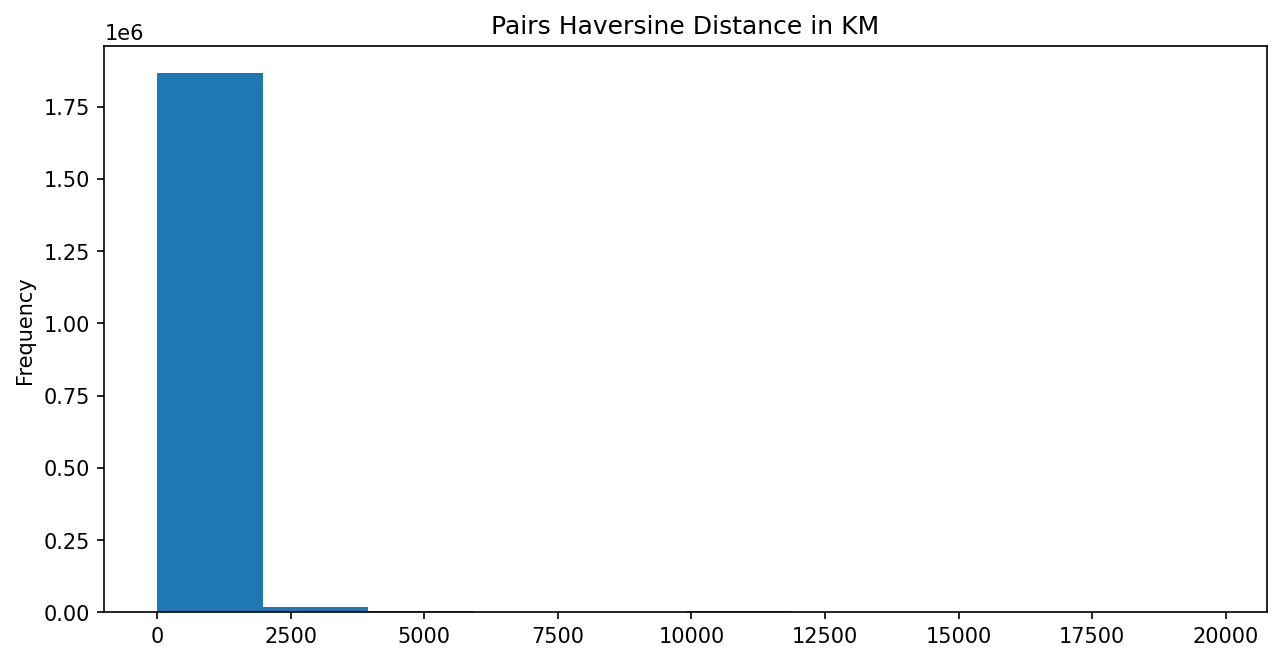

,Train,Pairs
count,1000000.000000,1.901006e+06
mean,8206.114258,1.810223e+02
std,4758.898438,9.845398e+02
min,0.000000,0.000000e+00
1%,106.019021,0.000000e+00
5%,752.458987,1.101249e-02
10%,1458.970703,2.145528e-02
25%,3996.121948,8.008592e-02
50%,8578.629395,7.152827e-01
90%,15173.820020,1.831182e+02


In [22]:
plot_distances()